https://www.kaggle.com/datasets/yashdevladdha/uber-ride-analytics-dashboard/data

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [2]:
from pyspark.sql.types import StructType, StructField, IntegerType, TimestampType, StringType, DateType, FloatType
from pyspark.sql import functions as F

schema = StructType([
  StructField("Date", DateType(), True),
  StructField("Time", TimestampType(), True),
  StructField("Booking ID", StringType(), True),
  StructField("Booking Status", StringType(), True),
  StructField("Customer ID", StringType(), True),
  StructField("Vehicle Type", StringType(), True),
  StructField("Pickup Location", StringType(), True),
  StructField("Drop Location", StringType(), True),
  StructField("Avg VTAT", FloatType(), True),
  StructField("Avg CTAT", FloatType(), True),
  StructField("Cancelled Rides by Customer", IntegerType(), True),
  StructField("Reason for cancelling by Customer", StringType(), True),
  StructField("Cancelled Rides by Driver", IntegerType(), True),
  StructField("Driver Cancellation Reason", StringType(), True),
  StructField("Incomplete Rides", IntegerType(), True),
  StructField("Incomplete Rides Reason", StringType(), True),
  StructField("Booking Value", FloatType(), True),
  StructField("Ride Distance", FloatType(), True),
  StructField("Driver Ratings", FloatType(), True),
  StructField("Customer Rating", FloatType(), True),
  StructField("Payment Method", StringType(), True),
  ])

In [3]:
import os
os.makedirs("/content/dataset", exist_ok=True)
!unzip -q "/content/drive/MyDrive/Colab Notebooks/PDS/uber_data_analytics_dashboard_dataset.zip" -d "/content/dataset"

In [4]:
df = spark.read.csv("/content/dataset/ncr_ride_bookings.csv", sep=',', schema=schema, header=True)
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Booking ID: string (nullable = true)
 |-- Booking Status: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Vehicle Type: string (nullable = true)
 |-- Pickup Location: string (nullable = true)
 |-- Drop Location: string (nullable = true)
 |-- Avg VTAT: float (nullable = true)
 |-- Avg CTAT: float (nullable = true)
 |-- Cancelled Rides by Customer: integer (nullable = true)
 |-- Reason for cancelling by Customer: string (nullable = true)
 |-- Cancelled Rides by Driver: integer (nullable = true)
 |-- Driver Cancellation Reason: string (nullable = true)
 |-- Incomplete Rides: integer (nullable = true)
 |-- Incomplete Rides Reason: string (nullable = true)
 |-- Booking Value: float (nullable = true)
 |-- Ride Distance: float (nullable = true)
 |-- Driver Ratings: float (nullable = true)
 |-- Customer Rating: float (nullable = true)
 |-- Payment Method: string (nullable = true)



In [5]:
df.show(5)

+----------+-------------------+----------------+---------------+----------------+-------------+-------------------+-----------------+--------+--------+---------------------------+---------------------------------+-------------------------+--------------------------+----------------+-----------------------+-------------+-------------+--------------+---------------+--------------+
|      Date|               Time|      Booking ID| Booking Status|     Customer ID| Vehicle Type|    Pickup Location|    Drop Location|Avg VTAT|Avg CTAT|Cancelled Rides by Customer|Reason for cancelling by Customer|Cancelled Rides by Driver|Driver Cancellation Reason|Incomplete Rides|Incomplete Rides Reason|Booking Value|Ride Distance|Driver Ratings|Customer Rating|Payment Method|
+----------+-------------------+----------------+---------------+----------------+-------------+-------------------+-----------------+--------+--------+---------------------------+---------------------------------+--------------------

/tmp/ipython-input-366242315.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x="Booking Status", y="count", data=booking_counts_df, palette="magma")


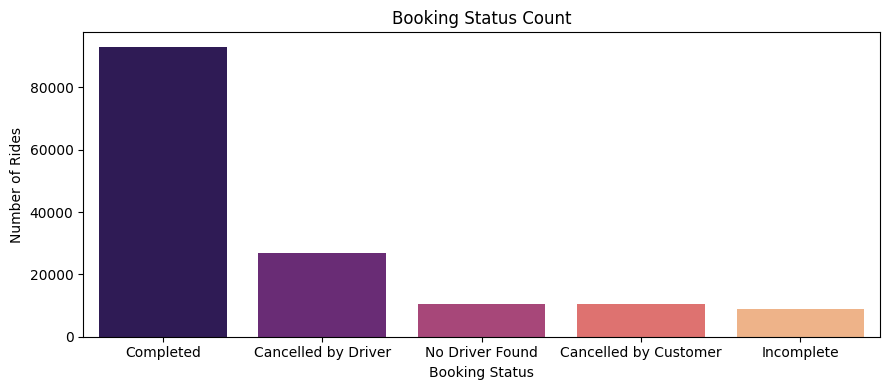

In [6]:
import matplotlib.pyplot as plt
import seaborn as sb

booking_counts = df.groupBy("Booking Status").count().orderBy(F.desc("count"))
booking_counts_df = booking_counts.toPandas()
plt.figure(figsize=(9, 4))
sb.barplot(x="Booking Status", y="count", data=booking_counts_df, palette="magma")
plt.title("Booking Status Count")
plt.ylabel("Number of Rides")
plt.xlabel("Booking Status")
plt.tight_layout()
plt.show()

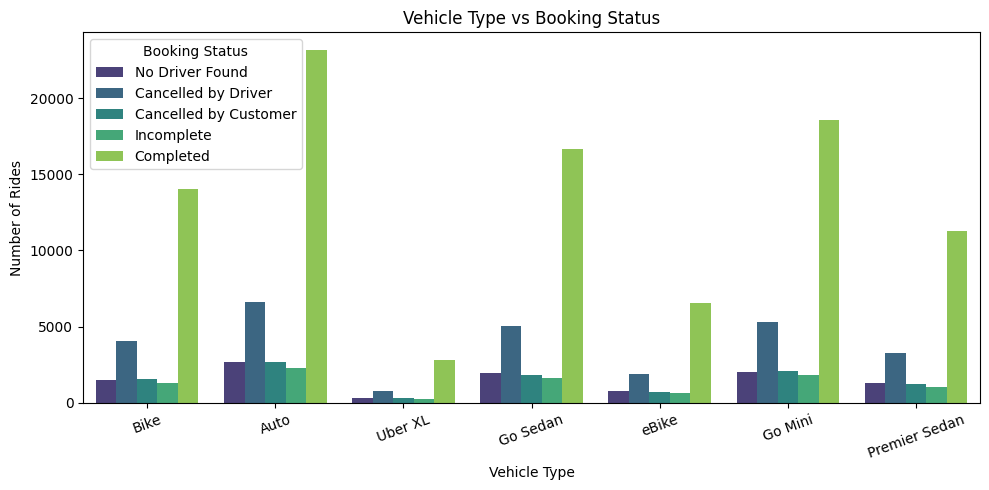

In [7]:
vehicle_status = df.groupBy("Vehicle Type", "Booking Status").count().toPandas()
plt.figure(figsize=(10, 5))
sb.barplot(x="Vehicle Type", y="count", hue="Booking Status", data=vehicle_status, palette="viridis")
plt.title("Vehicle Type vs Booking Status")
plt.ylabel("Number of Rides")
plt.xlabel("Vehicle Type")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

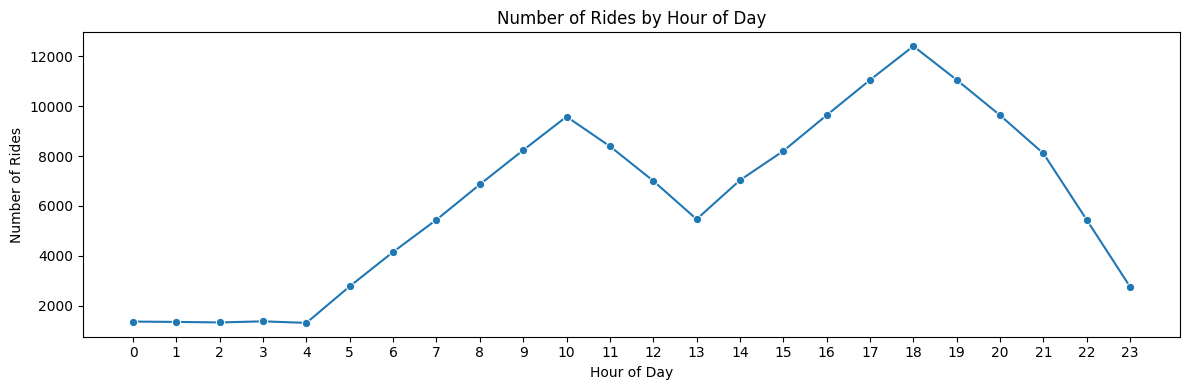

In [8]:
df_time = df.withColumn("hour_of_day", F.hour("Time"))
rides_hour = df_time.groupBy("hour_of_day").count().orderBy("hour_of_day").toPandas()
plt.figure(figsize=(12, 4))
sb.lineplot(x="hour_of_day", y="count", data=rides_hour, marker="o")
plt.title("Number of Rides by Hour of Day")
plt.ylabel("Number of Rides")
plt.xlabel("Hour of Day")
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()

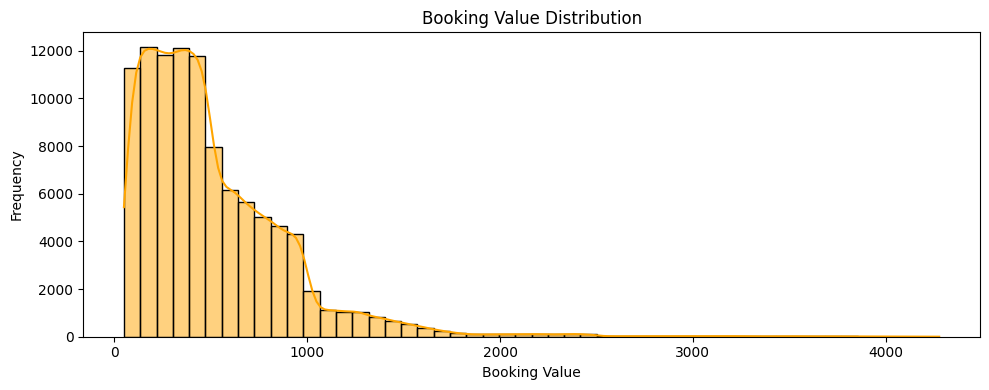

In [9]:
values = df.select("Booking Value").dropna().toPandas()
plt.figure(figsize=(10,4))
sb.histplot(values["Booking Value"], bins=50, kde=True, color="orange")
plt.title("Booking Value Distribution")
plt.xlabel("Booking Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

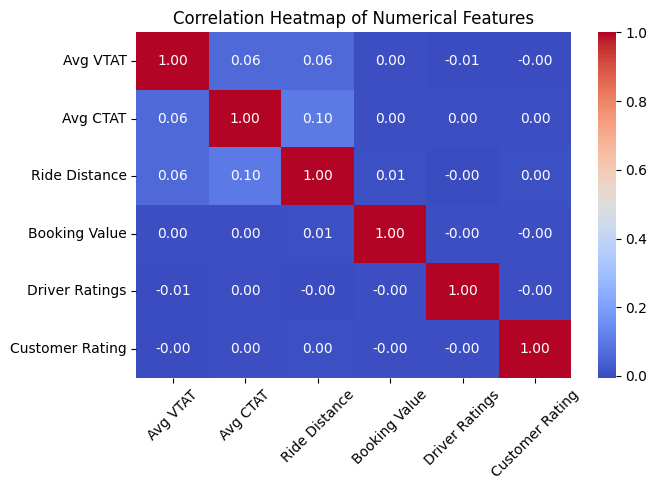

In [10]:
num_cols = ["Avg VTAT", "Avg CTAT", "Ride Distance", "Booking Value", "Driver Ratings", "Customer Rating"]
num_data = df.select(num_cols).toPandas()
plt.figure(figsize=(7,5))
corr = num_data.corr()
sb.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Customer cancellation reasons (exclude nulls or empty strings)
cancelled_by_customer = (
    df.filter(
        (F.col("Reason for cancelling by Customer").isNotNull()) &
        (F.trim(F.col("Reason for cancelling by Customer")) != "null")
    )
    .groupBy("Reason for cancelling by Customer")
    .count()
    .orderBy(F.desc("count"))
    .toPandas()
)

# Driver cancellation reasons (exclude nulls or empty strings)
cancelled_by_driver = (
    df.filter(
        (F.col("Driver Cancellation Reason").isNotNull()) &
        (F.trim(F.col("Driver Cancellation Reason")) != "null")
    )
    .groupBy("Driver Cancellation Reason")
    .count()
    .orderBy(F.desc("count"))
    .toPandas()
)


/tmp/ipython-input-1876063840.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(
/tmp/ipython-input-1876063840.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(


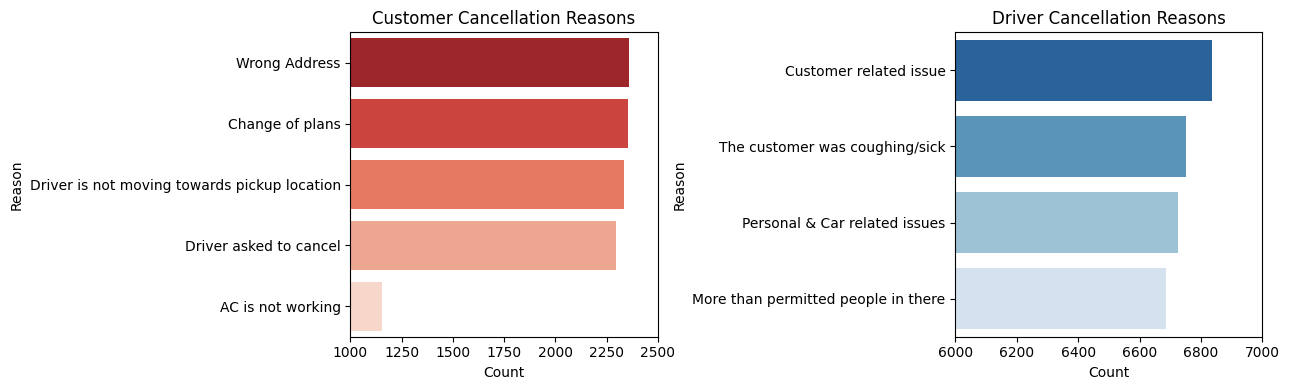

In [12]:
# Create a figure with 2 subplots, side by side
fig, axes = plt.subplots(1, 2, figsize=(13, 4), sharey=False)

# Customer Cancellation Reasons
sb.barplot(
    x="count",
    y="Reason for cancelling by Customer",
    data=cancelled_by_customer.sort_values("count", ascending=False),
    palette="Reds_r",
    ax=axes[0]
)
axes[0].set_xlim(1000, 2500)
axes[0].set_title("Customer Cancellation Reasons")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Reason")

# Driver Cancellation Reasons
sb.barplot(
    x="count",
    y="Driver Cancellation Reason",
    data=cancelled_by_driver.sort_values("count", ascending=False),
    palette="Blues_r",
    ax=axes[1]
)
axes[1].set_xlim(6000, 7000)
axes[1].set_title("Driver Cancellation Reasons")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Reason")

plt.tight_layout()
plt.show()


Target variable distribution:
+-----+-----+
|label|count|
+-----+-----+
|  0.0|57000|
|  1.0|93000|
+-----+-----+



/tmp/ipython-input-4245657210.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x="label", y="count", data=df_ml_dis_pandas, palette="magma")


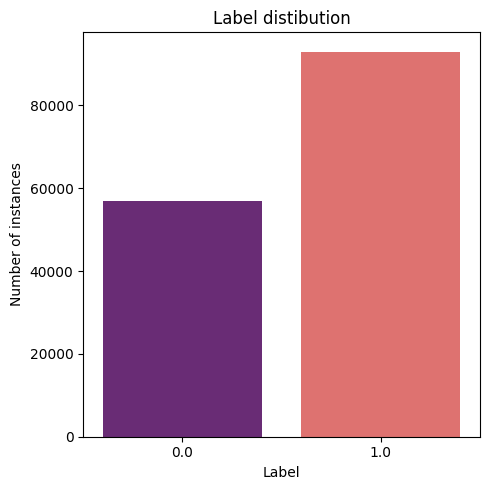

In [13]:
from pyspark.sql import functions as F

df_ml = df.withColumn("label", F.when(F.col("Booking Status") == "Completed", 1.0).otherwise(0.0))

df_ml = df_ml.withColumn("hour_of_day", F.hour(F.col("Time"))) \
             .withColumn("day_of_week", F.dayofweek(F.col("Date")))

print("Target variable distribution:")
df_ml_dis = df_ml.groupBy("label").count()
df_ml_dis.show()

df_ml_dis_pandas = df_ml_dis.toPandas()
plt.figure(figsize=(5, 5))
sb.barplot(x="label", y="count", data=df_ml_dis_pandas, palette="magma")
plt.title("Label distibution")
plt.ylabel("Number of instances")
plt.xlabel("Label")
plt.tight_layout()
plt.show()

In [14]:
df.columns

['Date',
 'Time',
 'Booking ID',
 'Booking Status',
 'Customer ID',
 'Vehicle Type',
 'Pickup Location',
 'Drop Location',
 'Avg VTAT',
 'Avg CTAT',
 'Cancelled Rides by Customer',
 'Reason for cancelling by Customer',
 'Cancelled Rides by Driver',
 'Driver Cancellation Reason',
 'Incomplete Rides',
 'Incomplete Rides Reason',
 'Booking Value',
 'Ride Distance',
 'Driver Ratings',
 'Customer Rating',
 'Payment Method']

In [15]:
from pyspark.ml.feature import Imputer

numerical_cols = ["Avg VTAT", "Avg CTAT", "Ride Distance", "Booking Value"]

imputer = Imputer(
    inputCols=numerical_cols,
    outputCols=[col + "_imputed" for col in numerical_cols]
).setStrategy("mean")

model = imputer.fit(df_ml)
df_imputed = model.transform(df_ml)

for old_col, new_col in zip(model.getOutputCols(), numerical_cols):
    df_imputed = df_imputed.drop(new_col).withColumnRenamed(old_col, new_col)

df_cleaned = df_imputed

df_cleaned.select(numerical_cols).show(5)


+--------+---------+-------------+-------------+
|Avg VTAT| Avg CTAT|Ride Distance|Booking Value|
+--------+---------+-------------+-------------+
|8.456352|29.149637|    24.637012|     508.2959|
|     4.9|     14.0|         5.73|        237.0|
|    13.4|     25.8|        13.58|        627.0|
|    13.1|     28.5|        34.02|        416.0|
|     5.3|     19.6|        48.21|        737.0|
+--------+---------+-------------+-------------+
only showing top 5 rows



In [16]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder

categorical_cols = ["Vehicle Type", "Payment Method"]
numerical_cols = ["Avg VTAT", "Avg CTAT", "Ride Distance", "Booking Value", "hour_of_day", "day_of_week"]

indexers = [
    StringIndexer(inputCol=col, outputCol=col + "_indexed", handleInvalid="keep")
    for col in categorical_cols
]

encoders = [
    OneHotEncoder(inputCol=col + "_indexed", outputCol=col + "_encoded")
    for col in categorical_cols
]

feature_cols = [col + "_encoded" for col in categorical_cols] + numerical_cols
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

from pyspark.ml import Pipeline
transformation_pipeline = Pipeline(stages=indexers + encoders + [assembler])

df_features = transformation_pipeline.fit(df_cleaned).transform(df_cleaned)

df_features.select("features", "label").show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                             |label|
+---------------------------------------------------------------------------------------------------------------------+-----+
|(19,[5,7,13,14,15,16,17,18],[1.0,1.0,8.456352233886719,29.14963722229004,24.637012481689453,508.2958984375,12.0,7.0])|0.0  |
|(19,[2,8,13,14,15,16,17,18],[1.0,1.0,4.900000095367432,14.0,5.730000019073486,237.0,18.0,6.0])                       |0.0  |
|(19,[0,12,13,14,15,16,17,18],[1.0,1.0,13.399999618530273,25.799999237060547,13.579999923706055,627.0,8.0,6.0])       |1.0  |
|(19,[4,8,13,14,15,16,17,18],[1.0,1.0,13.100000381469727,28.5,34.02000045776367,416.0,17.0,2.0])                      |1.0  |
|(19,[3,8,13,14,15,16,17,18],[1.0,1.0,5.300000190734863,19.600000381469727,48.209999084472656,737.0,22.0,2.0])        

In [17]:
input_dim = df_features.select("features").first()["features"].size

In [22]:
from pyspark.ml.classification import (
    DecisionTreeClassifier,
    RandomForestClassifier,
    NaiveBayes,
    GBTClassifier,
    LinearSVC,
    MultilayerPerceptronClassifier,
)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd

models = {
    "Decision Tree": DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=10),
    "Random Forest": RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100),
    "Naive Bayes": NaiveBayes(labelCol="label", featuresCol="features"),
    "Gradient Boosted Trees": GBTClassifier(labelCol="label", featuresCol="features", maxIter=50),
    "LinearSVC": LinearSVC(labelCol="label", featuresCol="features", maxIter=50),
    "Neural Network (MLP)": MultilayerPerceptronClassifier(
        labelCol="label",
        featuresCol="features",
        layers=[input_dim, 32, 16, 2],
        blockSize=128,
        seed=42
    )
}

multi_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

train_data, test_data = df_features.randomSplit([0.7, 0.3], seed=42)

In [28]:
results = []
trained_models = dict()

for name, model in models.items():
    print(f"\nTraining {name}...")
    trained_model = model.fit(train_data)
    preds = trained_model.transform(test_data)
    trained_models[name] = trained_model

    acc = multi_eval.setMetricName("accuracy").evaluate(preds)
    f1 = multi_eval.setMetricName("f1").evaluate(preds)
    prec = multi_eval.setMetricName("weightedPrecision").evaluate(preds)
    rec = multi_eval.setMetricName("weightedRecall").evaluate(preds)

    results.append((name, acc, f1, prec, rec))
    print(f"{name} trained | Accuracy={acc:.3f}, F1={f1:.3f}")


Training Decision Tree...
Decision Tree trained | Accuracy=0.953, F1=0.952

Training Random Forest...
Random Forest trained | Accuracy=0.945, F1=0.945

Training Naive Bayes...
Naive Bayes trained | Accuracy=0.833, F1=0.835

Training Gradient Boosted Trees...
Gradient Boosted Trees trained | Accuracy=0.954, F1=0.953

Training LinearSVC...
LinearSVC trained | Accuracy=0.940, F1=0.939

Training Neural Network (MLP)...
Neural Network (MLP) trained | Accuracy=0.937, F1=0.935


In [29]:
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1", "Precision", "Recall"])
results_df = results_df.sort_values(by="F1", ascending=False)
display(results_df)

,Model,Accuracy,F1,Precision,Recall
3,Gradient Boosted Trees,0.953735,0.953174,0.956059,0.953735
0,Decision Tree,0.952735,0.952180,0.954872,0.952735
1,Random Forest,0.945487,0.944571,0.949654,0.945487
4,LinearSVC,0.940462,0.939314,0.945694,0.940462
5,Neural Network (MLP),0.936505,0.935373,0.940795,0.936505
2,Naive Bayes,0.832904,0.835196,0.852803,0.832904


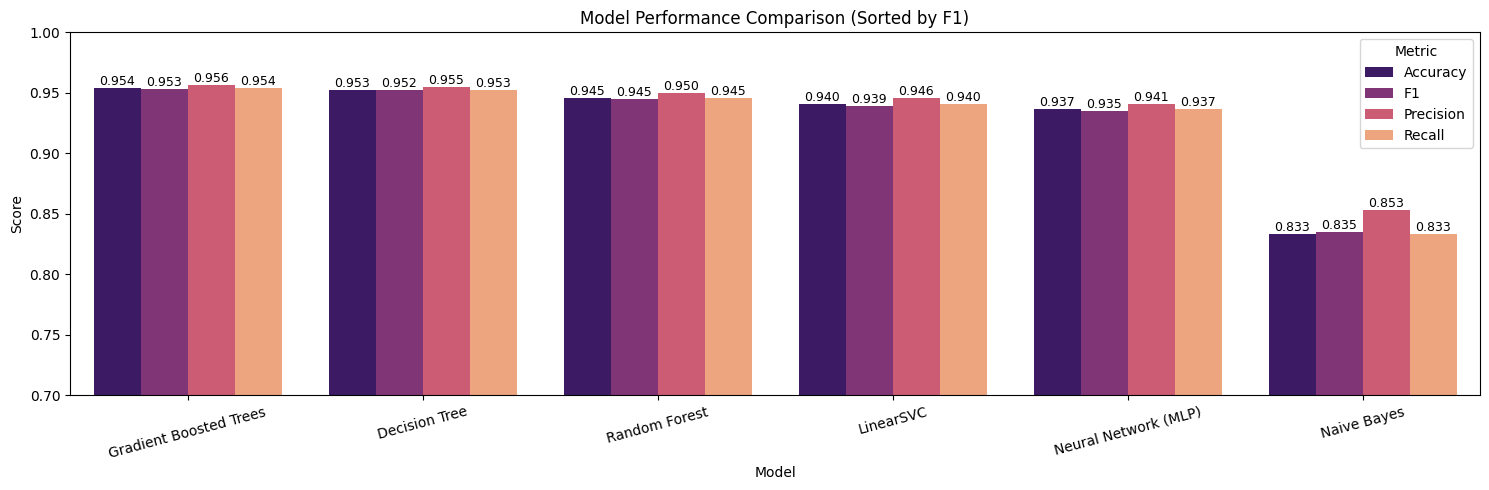

In [30]:
plt.figure(figsize=(15, 5))
results_melted = results_df.melt(
    id_vars="Model",
    value_vars=["Accuracy", "F1", "Precision", "Recall"],
    var_name="Metric",
    value_name="Score"
)

ax = sb.barplot(
    data=results_melted,
    x="Model",
    y="Score",
    hue="Metric",
    palette="magma"
)

# Add numbers on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.3f}",
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=9, color='black', rotation=0)

plt.title("Model Performance Comparison (Sorted by F1)")
plt.ylim(0.7, 1)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [31]:
best_model_name = results_df.loc[results_df["F1"].idxmax(), "Model"]
best_model = trained_models[best_model_name]
best_predictions = best_model.transform(test_data)

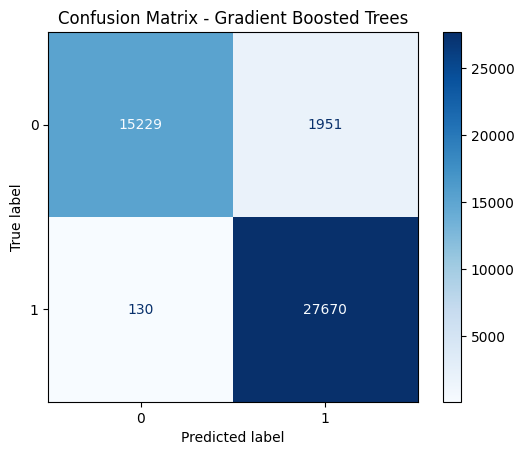

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = best_predictions.select("label").toPandas()
y_pred = best_predictions.select("prediction").toPandas()

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format=".0f")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()
